# 1. Постановка задачі та підготовка даних

In [391]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder, StandardScaler

In [159]:
ds = pd.read_csv('calories.csv')

In [160]:
ds.head()

,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,14733363,male,68,190.0,94.0,29.0,105.0,40.8,231.0
1,14861698,female,20,166.0,60.0,14.0,94.0,40.3,66.0
2,11179863,male,69,179.0,79.0,5.0,88.0,38.7,26.0
3,16180408,female,34,179.0,71.0,13.0,100.0,40.5,71.0
4,17771927,female,27,154.0,58.0,10.0,81.0,39.8,35.0


In [161]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   User_ID     15000 non-null  int64  
 1   Gender      15000 non-null  object 
 2   Age         15000 non-null  int64  
 3   Height      15000 non-null  float64
 4   Weight      15000 non-null  float64
 5   Duration    15000 non-null  float64
 6   Heart_Rate  15000 non-null  float64
 7   Body_Temp   15000 non-null  float64
 8   Calories    15000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 1.0+ MB


<Axes: >

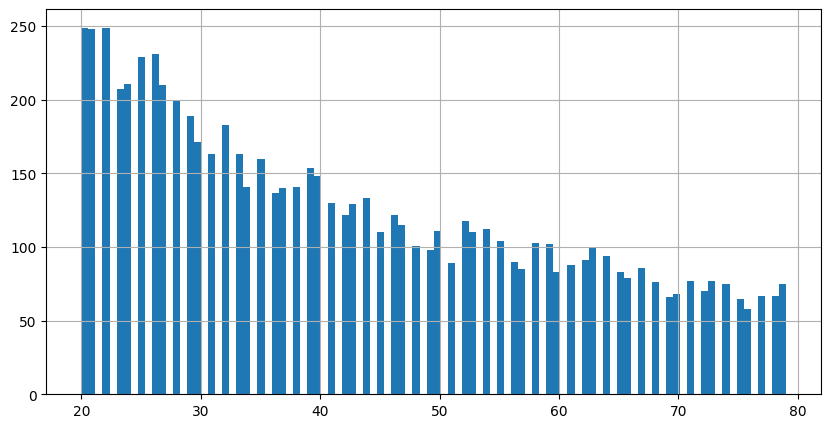

In [32]:
ds[ds['Gender'] == 'female']['Age'].hist(bins=100, figsize=(10, 5))

In [ ]:
# one-hot using pd (works but cliche)
# ds = pd.get_dummies(ds, columns=['Gender'], drop_first=True)

In [162]:
# works!
encoder = LabelEncoder()
ds['Gender'] = encoder.fit_transform(ds['Gender'])

In [163]:
ds.head()

,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,14733363,1,68,190.0,94.0,29.0,105.0,40.8,231.0
1,14861698,0,20,166.0,60.0,14.0,94.0,40.3,66.0
2,11179863,1,69,179.0,79.0,5.0,88.0,38.7,26.0
3,16180408,0,34,179.0,71.0,13.0,100.0,40.5,71.0
4,17771927,0,27,154.0,58.0,10.0,81.0,39.8,35.0


In [164]:
X = ds.drop('Calories', axis=1)
y = ds['Calories']

In [165]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [166]:
X_train.shape[0], X_test.shape[0]

(12000, 3000)

In [167]:
X_train.isnull().sum()

User_ID       0
Gender        0
Age           0
Height        0
Weight        0
Duration      0
Heart_Rate    0
Body_Temp     0
dtype: int64

## 😳

In [168]:
scaler = StandardScaler()
scale_data = lambda x: pd.DataFrame(scaler.fit_transform(x), columns=x.columns, index=x.index)
X_train_scaled = scale_data(X_train)
X_test_scaled = scale_data(X_test)

In [169]:
X_train

,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
9839,16554569,1,37,179.0,77.0,7.0,81.0,39.5
9680,18903739,1,23,195.0,87.0,26.0,110.0,40.5
7093,11938260,1,33,181.0,77.0,12.0,88.0,40.1
11293,14116395,0,66,156.0,54.0,9.0,77.0,39.5
820,13815395,0,32,144.0,49.0,5.0,90.0,39.0
...,...,...,...,...,...,...,...,...
5191,11890347,0,75,148.0,51.0,22.0,104.0,40.6
13418,13504073,0,21,172.0,67.0,20.0,104.0,40.7
5390,17918506,1,57,189.0,92.0,8.0,90.0,39.5
860,12133833,1,35,174.0,76.0,12.0,97.0,40.2


# II. Розв’язання задачі ймовірнісної регресії

1. Навчити регресійні моделі (наприклад, лінійну регресію, випадковий ліс, 
градієнтний бустинг).
2. Додати ймовірнісні межі (min/max) для кожного прогнозу (наприклад, 
довірчі інтервали 95%) використовуючи підхід на ваш вибір.
3. Перевірити якість регресійної моделі за допомогою метрик:
• MAE (Mean Absolute Error)
• RMSE (Root Mean Square Error)
• R² (коефіцієнт детермінації)
4. Оптимізувати гіперпараметри моделі (наприклад, кількість дерев у 
випадку Random Forest).
5. Повторно валідувати модель після оптимізації та оцінити зміни.


In [546]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

import statsmodels.api as sm
import matplotlib.pylab as plt

class MetricsManager:
  @staticmethod
  def print_metrics(y_test, y_pred, prefix_str="") -> list[float, float, float]:
    mae = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print("{} - MAE: {:.3f}, RMSE: {:.3f}, R^2: {:.3f}".format(prefix_str, mae, rmse, r2))
    return [mae, rmse, r2]
  @staticmethod
  def confidence_intervals(X_train_scaled, y_train, X_test_scaled):
    X_train_sm = sm.add_constant(X_train_scaled)
    X_test_sm = sm.add_constant(X_test_scaled)

    ols_model = sm.OLS(y_train, X_train_sm).fit()
    pred_sm = ols_model.get_prediction(X_test_sm)
    pred_summary = pred_sm.summary_frame(alpha=0.05) # 95% interval
    #display(pred_summary.head())
    pred_summary.head()
    return pred_summary
  @staticmethod
  def visualise_metrics(y_test, y_pred, pred_summary, title="", values_num=50) -> None:
    plt.figure(figsize=(15, 5))
    plt.plot(y_test.values[:values_num], 'bo-', label='Real Values')
    plt.plot(y_pred[:values_num], 'ro-', label='Predicted Values')
    plt.fill_between(
      np.arange(values_num),
      pred_summary['obs_ci_lower'][:values_num],
      pred_summary['obs_ci_upper'][:values_num],
      color='gray', alpha=0.2, label='95%'
    )
    plt.legend()
    plt.xlabel('Record Index')
    plt.ylabel('Target')
    plt.title(title)
    plt.show()
    
  @staticmethod
  def print_classification_metrics(y_true, y_pred, model_name) -> tuple:
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='weighted')
    rec = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    print(f"{model_name} - Accuracy: {acc:.3f}, Precision: {prec:.3f}, Recall: {rec:.3f}, F1-score: {f1:.3f}")
    print("Confusion Matrix")
    print(confusion_matrix(y_true, y_pred))
    print('\nClassification Report:\n', classification_report(y_true, y_pred))
    return acc, prec, rec, f1

In [171]:
from sklearn.linear_model import LinearRegression

In [421]:
def check_model_metrics(model, X_train_scaled, y_train, X_test_scaled, y_test) -> tuple[str, list[int, int, int]]:
  model.fit(X_train_scaled, y_train)
  y_pred = model.predict(X_test_scaled)
  
  model_name = type(model).__name__
  mae, rmse, r2 = MetricsManager.print_metrics(y_test, y_pred, model_name)
  pred_summary = MetricsManager.confidence_intervals(X_train_scaled, y_train, X_test_scaled)
  MetricsManager.visualise_metrics(y_test, y_pred, pred_summary, title=f"{model_name} predictions 95% percentile", values_num=100)
  return model_name, [mae, rmse, r2]
  

In [422]:
metrics_map = {}
def checker_wrapper(model) -> None:
  model_name, metrics = check_model_metrics(model, X_train_scaled, y_train, X_test_scaled, y_test)
  metrics_map[model_name] = metrics 

In [394]:
model = LinearRegression()
model.fit(X_train_scaled, y_train)

LinearRegression()

In [395]:
y_pred = model.predict(X_test_scaled)
MetricsManager.print_metrics(y_test, y_pred, "Linear Regression")

Linear Regression - MAE: 138.167, RMSE: 11.754, R^2: 0.966


[138.16707086101633, 11.75444898159911, 0.9657645664705375]

In [396]:
X_train_sm = sm.add_constant(X_train_scaled)
X_test_sm = sm.add_constant(X_test_scaled)

ols_model = sm.OLS(y_train, X_train_sm).fit()

In [403]:
pred_sm = ols_model.get_prediction(X_test_sm)
pred_summary = pred_sm.summary_frame(alpha=0.05) # 95% interval
pred_summary

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
11499,167.589857,0.267400,167.065710,168.114004,145.492443,189.687271
6475,188.775184,0.342663,188.103508,189.446859,166.673778,210.876589
13167,54.847700,0.265016,54.328226,55.367175,32.750397,76.945004
862,152.817305,0.275093,152.278077,153.356533,130.719528,174.915082
5970,209.049664,0.341590,208.380092,209.719235,186.948322,231.151005
...,...,...,...,...,...,...
6216,182.370381,0.294673,181.792775,182.947987,160.271634,204.469128
3585,59.687386,0.285250,59.128250,60.246523,37.589115,81.785658
10023,126.989842,0.236859,126.525559,127.454125,104.893767,149.085917
14044,1.876838,0.340856,1.208705,2.544971,-20.224460,23.978136


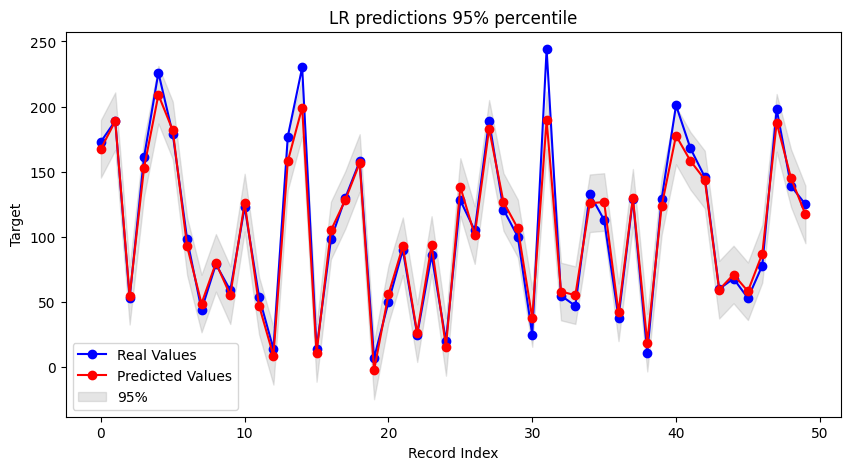

In [407]:
MetricsManager.visualise_metrics(y_test, y_pred, pred_summary, title="LR predictions 95% percentile")

In [179]:
models = []

LinearRegression - MAE: 138.167, RMSE: 11.754, R^2: 0.966


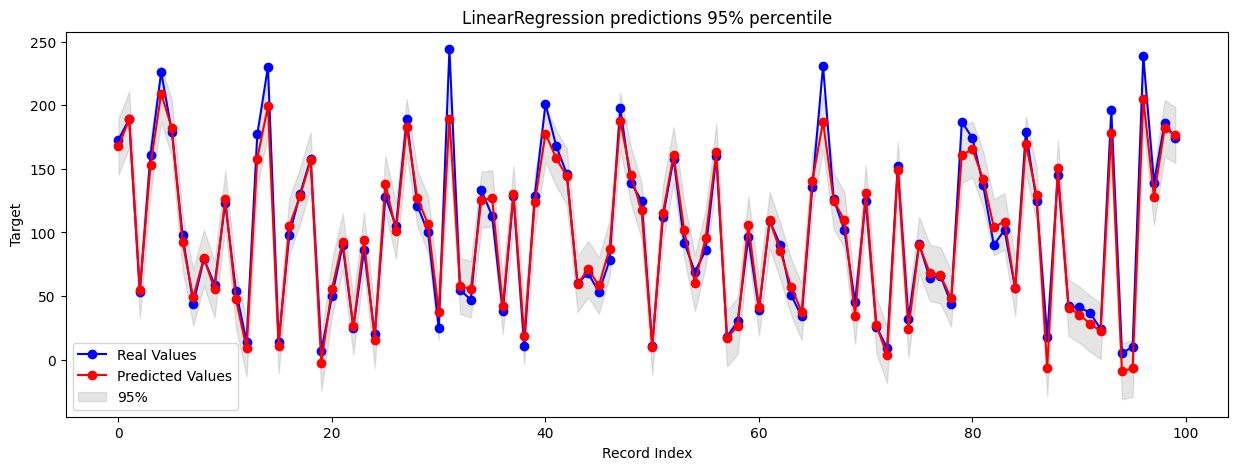

('LinearRegression',
 [138.16707086101633, 11.75444898159911, 0.9657645664705375])

In [423]:
lr_model = LinearRegression()
models.append(lr_model)
check_model_metrics(lr_model, X_train_scaled, y_train, X_test_scaled, y_test)

Lasso - MAE: 165.677, RMSE: 12.872, R^2: 0.959


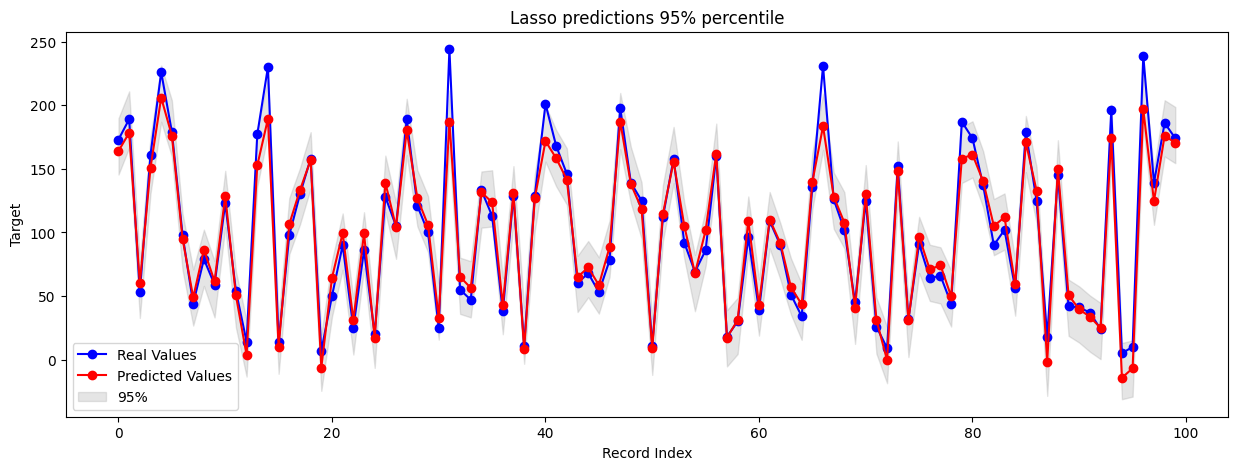

('Lasso', [165.67687364724767, 12.871552884063666, 0.9589481085487798])

In [424]:
from sklearn.linear_model import Lasso
ls_model = Lasso(random_state=42)
models.append(ls_model)
check_model_metrics(ls_model, X_train_scaled, y_train, X_test_scaled, y_test)

Ridge - MAE: 138.180, RMSE: 11.755, R^2: 0.966


,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
11499,167.589857,0.267400,167.065710,168.114004,145.492443,189.687271
6475,188.775184,0.342663,188.103508,189.446859,166.673778,210.876589
13167,54.847700,0.265016,54.328226,55.367175,32.750397,76.945004
862,152.817305,0.275093,152.278077,153.356533,130.719528,174.915082
5970,209.049664,0.341590,208.380092,209.719235,186.948322,231.151005


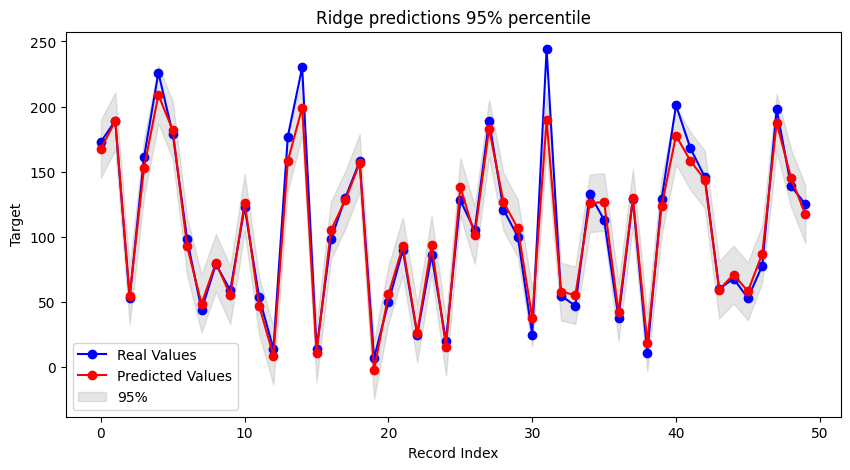

('Ridge', [138.17987495354586, 11.754993617758618, 0.9657613938357269])

In [182]:
from sklearn.linear_model import Ridge
ridge_model = Ridge()
models.append(ridge_model)
check_model_metrics(ridge_model, X_train_scaled, y_train, X_test_scaled, y_test)

ElasticNet - MAE: 420.365, RMSE: 20.503, R^2: 0.896


,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
11499,167.589857,0.267400,167.065710,168.114004,145.492443,189.687271
6475,188.775184,0.342663,188.103508,189.446859,166.673778,210.876589
13167,54.847700,0.265016,54.328226,55.367175,32.750397,76.945004
862,152.817305,0.275093,152.278077,153.356533,130.719528,174.915082
5970,209.049664,0.341590,208.380092,209.719235,186.948322,231.151005


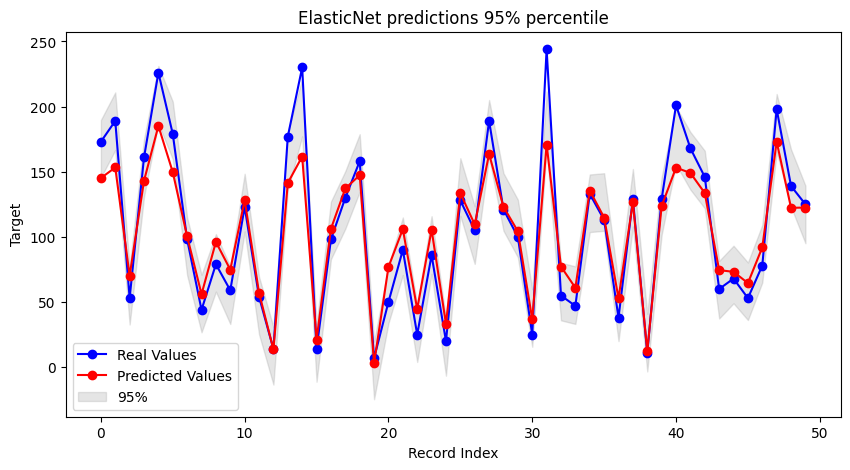

('ElasticNet', [420.36538397362295, 20.50281405011573, 0.8958406581869831])

In [183]:
from sklearn.linear_model import ElasticNet
elastic_model = ElasticNet()
models.append(elastic_model)
check_model_metrics(elastic_model, X_train_scaled, y_train, X_test_scaled, y_test)

BayesianRidge - MAE: 138.171, RMSE: 11.755, R^2: 0.966


,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
11499,167.589857,0.267400,167.065710,168.114004,145.492443,189.687271
6475,188.775184,0.342663,188.103508,189.446859,166.673778,210.876589
13167,54.847700,0.265016,54.328226,55.367175,32.750397,76.945004
862,152.817305,0.275093,152.278077,153.356533,130.719528,174.915082
5970,209.049664,0.341590,208.380092,209.719235,186.948322,231.151005


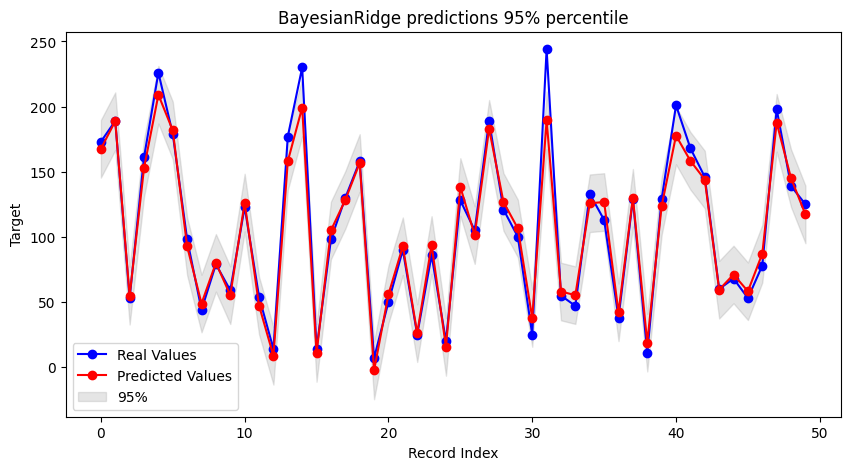

('BayesianRidge', [138.1705902175247, 11.754598683814123, 0.965763694434277])

In [184]:
from sklearn.linear_model import BayesianRidge
bayes_model = BayesianRidge()
models.append(bayes_model)
check_model_metrics(bayes_model, X_train_scaled, y_train, X_test_scaled, y_test)

RandomForestRegressor - MAE: 9.610, RMSE: 3.100, R^2: 0.998


,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
11499,167.589857,0.267400,167.065710,168.114004,145.492443,189.687271
6475,188.775184,0.342663,188.103508,189.446859,166.673778,210.876589
13167,54.847700,0.265016,54.328226,55.367175,32.750397,76.945004
862,152.817305,0.275093,152.278077,153.356533,130.719528,174.915082
5970,209.049664,0.341590,208.380092,209.719235,186.948322,231.151005


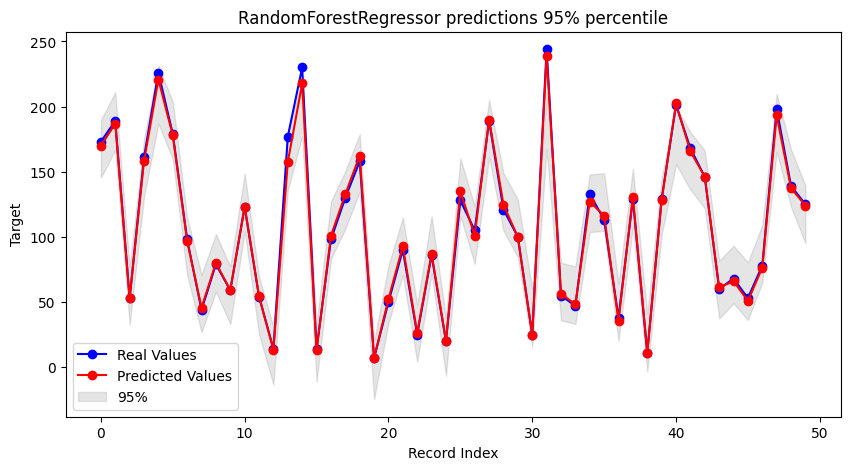

('RandomForestRegressor',
 [9.609988466666668, 3.0999981397843883, 0.9976188094650974])

In [185]:
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor()
models.append(rf_model)
check_model_metrics(rf_model, X_train_scaled, y_train, X_test_scaled, y_test)

In [186]:
from xgboost import XGBRegressor
xgb_model = XGBRegressor(tree_method="hist", early_stopping_rounds=2)
#check_model_metrics(xgb_model, X_train_scaled, y_train, X_test_scaled, y_test)
# xgb_model.fit(X_train_scaled, y_train)

Learning rate set to 0.06063
0:	learn: 58.7876314	total: 4.15ms	remaining: 4.14s
1:	learn: 55.6330751	total: 6.83ms	remaining: 3.41s
2:	learn: 52.6671971	total: 9.8ms	remaining: 3.26s
3:	learn: 49.8422989	total: 12.9ms	remaining: 3.22s
4:	learn: 47.2500117	total: 16ms	remaining: 3.19s
5:	learn: 44.7295965	total: 18.8ms	remaining: 3.11s
6:	learn: 42.3682425	total: 22.1ms	remaining: 3.13s
7:	learn: 40.0843673	total: 24.8ms	remaining: 3.07s
8:	learn: 37.9864623	total: 27.4ms	remaining: 3.02s
9:	learn: 36.0210642	total: 30ms	remaining: 2.97s
10:	learn: 34.1275729	total: 32.7ms	remaining: 2.94s
11:	learn: 32.4469302	total: 35.5ms	remaining: 2.92s
12:	learn: 30.7938772	total: 38.4ms	remaining: 2.92s
13:	learn: 29.2273172	total: 41.3ms	remaining: 2.91s
14:	learn: 27.7614328	total: 43.9ms	remaining: 2.88s
15:	learn: 26.3495847	total: 46.6ms	remaining: 2.86s
16:	learn: 25.0233332	total: 49ms	remaining: 2.83s
17:	learn: 23.8011500	total: 52.1ms	remaining: 2.84s
18:	learn: 22.6341571	total: 54.9m

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
11499,167.589857,0.267400,167.065710,168.114004,145.492443,189.687271
6475,188.775184,0.342663,188.103508,189.446859,166.673778,210.876589
13167,54.847700,0.265016,54.328226,55.367175,32.750397,76.945004
862,152.817305,0.275093,152.278077,153.356533,130.719528,174.915082
5970,209.049664,0.341590,208.380092,209.719235,186.948322,231.151005


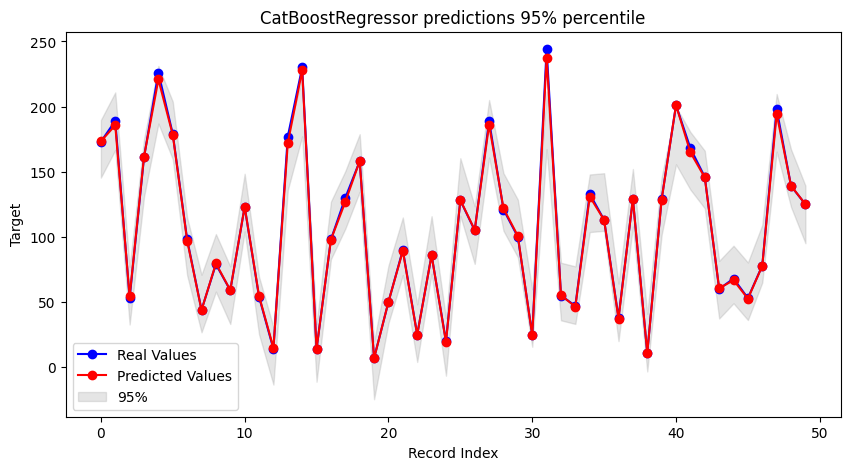

('CatBoostRegressor',
 [2.077488926107886, 1.4413496890442257, 0.9994852338289092])

In [187]:
from catboost import CatBoostRegressor 
cat_model = CatBoostRegressor()
models.append(cat_model)
check_model_metrics(cat_model, X_train_scaled, y_train, X_test_scaled, y_test)

KNeighborsRegressor - MAE: 53.381, RMSE: 7.306, R^2: 0.987


,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
11499,167.589857,0.267400,167.065710,168.114004,145.492443,189.687271
6475,188.775184,0.342663,188.103508,189.446859,166.673778,210.876589
13167,54.847700,0.265016,54.328226,55.367175,32.750397,76.945004
862,152.817305,0.275093,152.278077,153.356533,130.719528,174.915082
5970,209.049664,0.341590,208.380092,209.719235,186.948322,231.151005


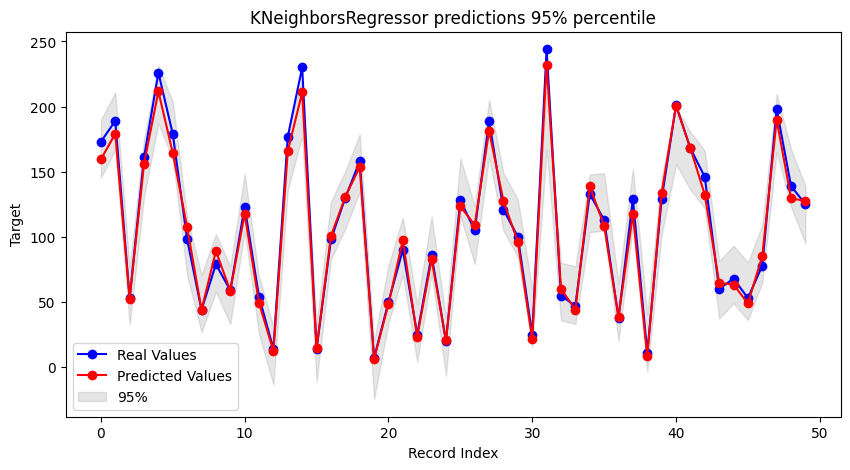

('KNeighborsRegressor',
 [53.38053333333333, 7.306198281824367, 0.986773218182074])

In [190]:
from sklearn.neighbors import KNeighborsRegressor
kn_model = KNeighborsRegressor()
models.append(kn_model)
check_model_metrics(kn_model, X_train_scaled, y_train, X_test_scaled, y_test)

LinearRegression - MAE: 138.167, RMSE: 11.754, R^2: 0.966


,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
11499,167.589857,0.267400,167.065710,168.114004,145.492443,189.687271
6475,188.775184,0.342663,188.103508,189.446859,166.673778,210.876589
13167,54.847700,0.265016,54.328226,55.367175,32.750397,76.945004
862,152.817305,0.275093,152.278077,153.356533,130.719528,174.915082
5970,209.049664,0.341590,208.380092,209.719235,186.948322,231.151005


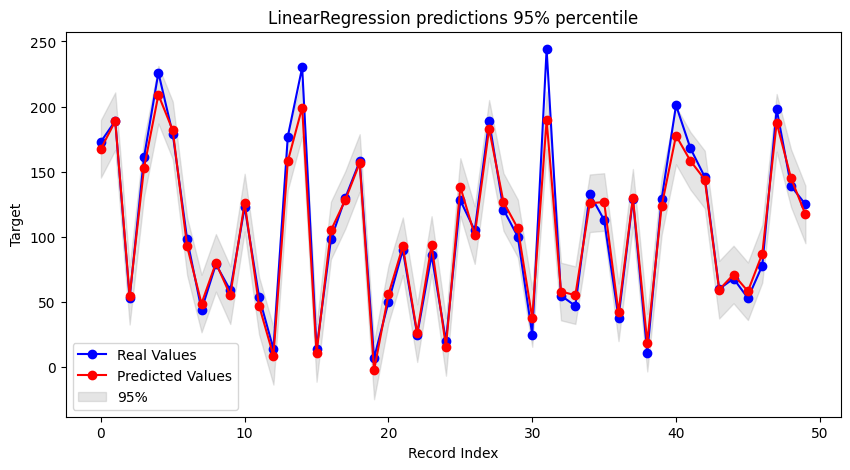

Lasso - MAE: 165.677, RMSE: 12.872, R^2: 0.959


,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
11499,167.589857,0.267400,167.065710,168.114004,145.492443,189.687271
6475,188.775184,0.342663,188.103508,189.446859,166.673778,210.876589
13167,54.847700,0.265016,54.328226,55.367175,32.750397,76.945004
862,152.817305,0.275093,152.278077,153.356533,130.719528,174.915082
5970,209.049664,0.341590,208.380092,209.719235,186.948322,231.151005


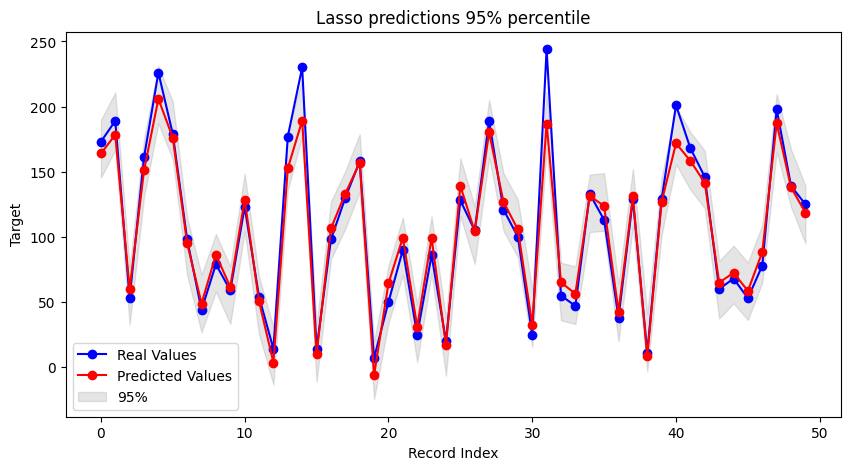

Ridge - MAE: 138.180, RMSE: 11.755, R^2: 0.966


,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
11499,167.589857,0.267400,167.065710,168.114004,145.492443,189.687271
6475,188.775184,0.342663,188.103508,189.446859,166.673778,210.876589
13167,54.847700,0.265016,54.328226,55.367175,32.750397,76.945004
862,152.817305,0.275093,152.278077,153.356533,130.719528,174.915082
5970,209.049664,0.341590,208.380092,209.719235,186.948322,231.151005


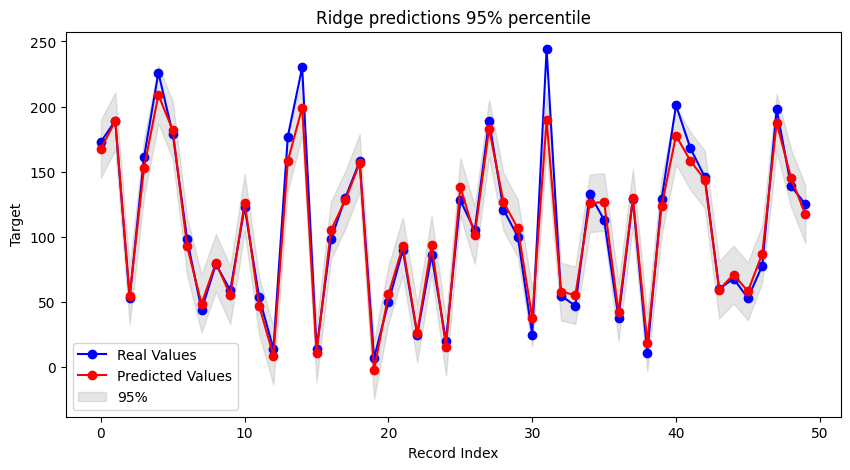

ElasticNet - MAE: 420.365, RMSE: 20.503, R^2: 0.896


,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
11499,167.589857,0.267400,167.065710,168.114004,145.492443,189.687271
6475,188.775184,0.342663,188.103508,189.446859,166.673778,210.876589
13167,54.847700,0.265016,54.328226,55.367175,32.750397,76.945004
862,152.817305,0.275093,152.278077,153.356533,130.719528,174.915082
5970,209.049664,0.341590,208.380092,209.719235,186.948322,231.151005


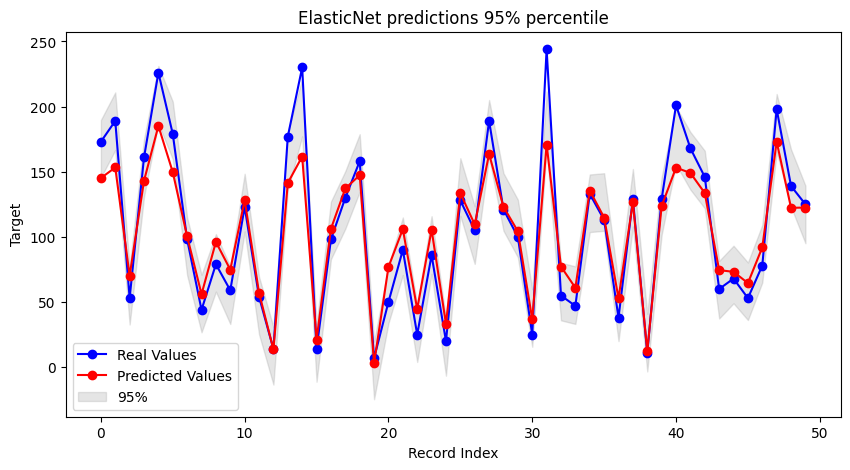

BayesianRidge - MAE: 138.171, RMSE: 11.755, R^2: 0.966


,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
11499,167.589857,0.267400,167.065710,168.114004,145.492443,189.687271
6475,188.775184,0.342663,188.103508,189.446859,166.673778,210.876589
13167,54.847700,0.265016,54.328226,55.367175,32.750397,76.945004
862,152.817305,0.275093,152.278077,153.356533,130.719528,174.915082
5970,209.049664,0.341590,208.380092,209.719235,186.948322,231.151005


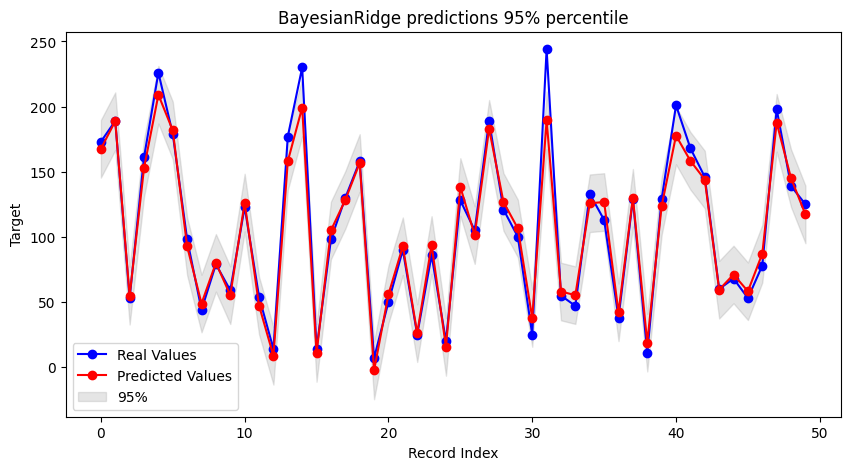

RandomForestRegressor - MAE: 9.633, RMSE: 3.104, R^2: 0.998


,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
11499,167.589857,0.267400,167.065710,168.114004,145.492443,189.687271
6475,188.775184,0.342663,188.103508,189.446859,166.673778,210.876589
13167,54.847700,0.265016,54.328226,55.367175,32.750397,76.945004
862,152.817305,0.275093,152.278077,153.356533,130.719528,174.915082
5970,209.049664,0.341590,208.380092,209.719235,186.948322,231.151005


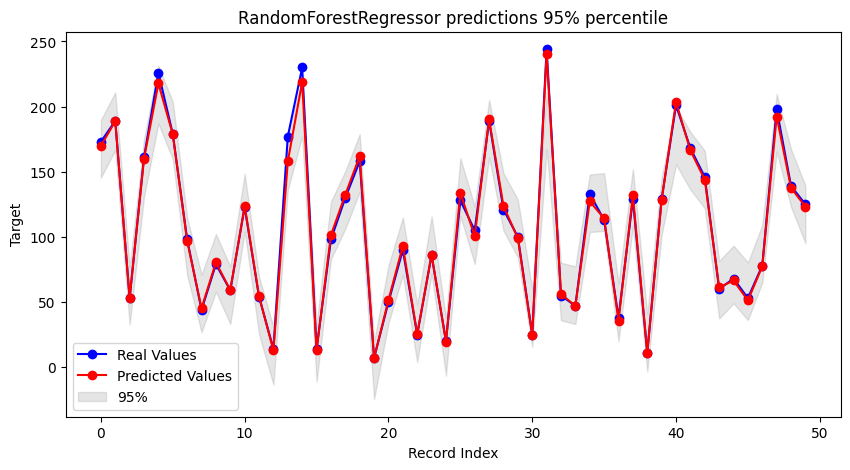

Learning rate set to 0.06063
0:	learn: 58.7876314	total: 2.94ms	remaining: 2.94s
1:	learn: 55.6330751	total: 5.47ms	remaining: 2.73s
2:	learn: 52.6671971	total: 8.01ms	remaining: 2.66s
3:	learn: 49.8422989	total: 11ms	remaining: 2.73s
4:	learn: 47.2500117	total: 14.2ms	remaining: 2.83s
5:	learn: 44.7295965	total: 17.3ms	remaining: 2.86s
6:	learn: 42.3682425	total: 19.9ms	remaining: 2.82s
7:	learn: 40.0843673	total: 22.3ms	remaining: 2.77s
8:	learn: 37.9864623	total: 25ms	remaining: 2.75s
9:	learn: 36.0210642	total: 27.8ms	remaining: 2.75s
10:	learn: 34.1275729	total: 30.5ms	remaining: 2.74s
11:	learn: 32.4469302	total: 33ms	remaining: 2.72s
12:	learn: 30.7938772	total: 35.5ms	remaining: 2.7s
13:	learn: 29.2273172	total: 38ms	remaining: 2.68s
14:	learn: 27.7614328	total: 40.6ms	remaining: 2.67s
15:	learn: 26.3495847	total: 43.5ms	remaining: 2.67s
16:	learn: 25.0233332	total: 46.2ms	remaining: 2.67s
17:	learn: 23.8011500	total: 48.6ms	remaining: 2.65s
18:	learn: 22.6341571	total: 51.2ms	

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
11499,167.589857,0.267400,167.065710,168.114004,145.492443,189.687271
6475,188.775184,0.342663,188.103508,189.446859,166.673778,210.876589
13167,54.847700,0.265016,54.328226,55.367175,32.750397,76.945004
862,152.817305,0.275093,152.278077,153.356533,130.719528,174.915082
5970,209.049664,0.341590,208.380092,209.719235,186.948322,231.151005


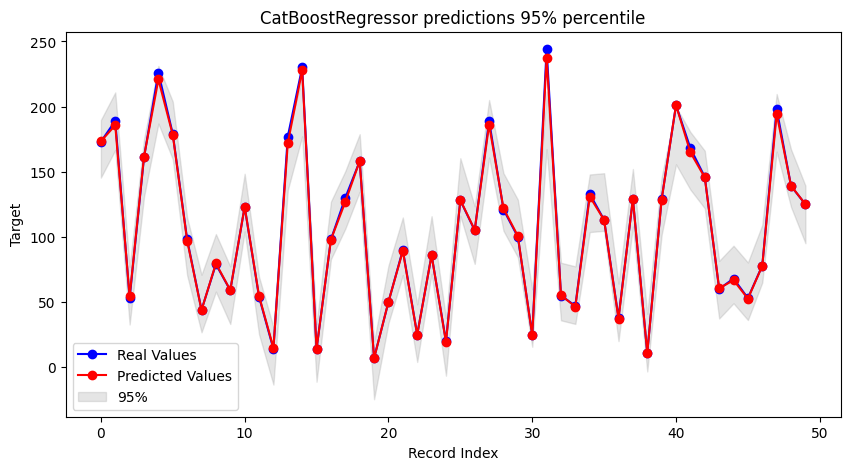

KNeighborsRegressor - MAE: 53.381, RMSE: 7.306, R^2: 0.987


,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
11499,167.589857,0.267400,167.065710,168.114004,145.492443,189.687271
6475,188.775184,0.342663,188.103508,189.446859,166.673778,210.876589
13167,54.847700,0.265016,54.328226,55.367175,32.750397,76.945004
862,152.817305,0.275093,152.278077,153.356533,130.719528,174.915082
5970,209.049664,0.341590,208.380092,209.719235,186.948322,231.151005


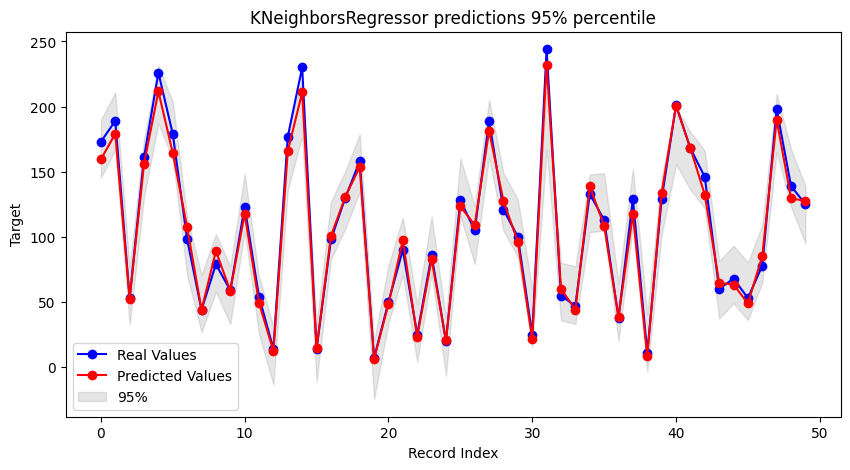

In [191]:
for model in models:
  checker_wrapper(model)

In [225]:
metrics_df = pd.DataFrame(metrics_map).T
metrics_df.rename({
  0: "mae",
  1: "rmse",
  2: "r2",
}, axis=1, inplace=True)
metrics_df

,mae,rmse,r2
LinearRegression,138.167071,11.754449,0.965765
Lasso,165.676874,12.871553,0.958948
Ridge,138.179875,11.754994,0.965761
ElasticNet,420.365384,20.502814,0.895841
BayesianRidge,138.170590,11.754599,0.965764
RandomForestRegressor,9.633164,3.103734,0.997613
CatBoostRegressor,2.077489,1.441350,0.999485
KNeighborsRegressor,53.380533,7.306198,0.986773


our competitors have assembled now let us choose the worsiest one💥

(kitty's the best😸)

In [227]:
metrics_df['mae'].sort_values()

CatBoostRegressor          2.077489
RandomForestRegressor      9.633164
KNeighborsRegressor       53.380533
LinearRegression         138.167071
BayesianRidge            138.170590
Ridge                    138.179875
Lasso                    165.676874
ElasticNet               420.365384
Name: mae, dtype: float64

In [228]:
metrics_df['rmse'].sort_values()

CatBoostRegressor         1.441350
RandomForestRegressor     3.103734
KNeighborsRegressor       7.306198
LinearRegression         11.754449
BayesianRidge            11.754599
Ridge                    11.754994
Lasso                    12.871553
ElasticNet               20.502814
Name: rmse, dtype: float64

In [231]:
metrics_df['r2'].sort_values(ascending=False)

CatBoostRegressor        0.999485
RandomForestRegressor    0.997613
KNeighborsRegressor      0.986773
LinearRegression         0.965765
BayesianRidge            0.965764
Ridge                    0.965761
Lasso                    0.958948
ElasticNet               0.895841
Name: r2, dtype: float64

alright, choosing the best ones'd be boring so lets choose three models at random and tune them

In [239]:
import random
random.choices(models, k=3)

[ElasticNet(), LinearRegression(), BayesianRidge()]

I got these
1. ElasticNet(), 
2. LinearRegression(), 
3. BayesianRidge()

### pipes🐱‍👤

we'll get back to the gridSearch in a minute I just wanna try using pipes

In [287]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [288]:
ds = pd.read_csv('calories.csv')
X = ds
y = ds['Calories']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [289]:
num_cols = [n for n in ds.columns if n != 'Gender' and n != 'Calories']
cat_cols = ['Gender']

In [293]:
num_preprocessor = Pipeline([
  ('scaler', StandardScaler())
])
cat_preprocessor = Pipeline([
  ('one_hot_encoder', OneHotEncoder())
])

In [294]:
preprocessor = ColumnTransformer(
  transformers=[
    ('num', num_preprocessor, num_cols),
    ('cat', cat_preprocessor, cat_cols)
  ]
)

In [295]:
pipe = Pipeline([
  ('preprocessor', preprocessor),
  ('model', lr_model)
])

In [296]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['User_ID', 'Age', 'Height',
                                                   'Weight', 'Duration',
                                                   'Heart_Rate', 'Body_Temp']),
                                                 ('cat',
                                                  Pipeline(steps=[('one_hot_encoder',
                                                                   OneHotEncoder())]),
                                                  ['Gender'])])),
                ('model', LinearRegression())])

In [305]:
mae, rmse, r2 = MetricsManager.print_metrics(y_test, y_pred, "pipe")

pipe - MAE: 132.068, RMSE: 11.492, R^2: 0.967


I guess it look all nice and clean but I kinda feel uneasy cause of that X=ds thing above.

and also I can't see the interprocess results which's like being blind(((

### GridSearch comes back

Let me remind you of our dear participants
1. ElasticNet(), 
2. LinearRegression(), 
3. BayesianRidge()

I'll not use pipe for this as I am not so sure whether I know about it good enough yet

In [307]:
ds = pd.read_csv('calories.csv')

encoder = LabelEncoder()
ds['Gender'] = encoder.fit_transform(ds['Gender'])

X = ds.drop('Calories', axis=1)
y = ds['Calories']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
scale_data = lambda x: pd.DataFrame(scaler.fit_transform(x), columns=x.columns, index=x.index)
X_train_scaled = scale_data(X_train)
X_test_scaled = scale_data(X_test)

our data is back

#### Linear Regressor

In [308]:
lr_model.get_params()

{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}

eeeehh, I knew u couldn't really tune but like...

#### KNeighborsRegressor      

In [309]:
kn_model.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [317]:
from sklearn.metrics import make_scorer

scoring = {
  'mae': make_scorer(mean_absolute_error),
  'msre': make_scorer(mean_squared_error),
  'r2': make_scorer(r2_score)
}

In [331]:
from sklearn.model_selection import GridSearchCV
kn_grid = GridSearchCV(
  estimator=kn_model,
  param_grid={
    'n_neighbors': [5, 10, 15]
  },
  cv=3,
  scoring=scoring,
  refit=False     # but why for gods sake
)
kn_grid

GridSearchCV(cv=3, estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': [5, 10, 15]}, refit=False,
             scoring={'mae': make_scorer(mean_absolute_error, response_method='predict'),
                      'msre': make_scorer(mean_squared_error, response_method='predict'),
                      'r2': make_scorer(r2_score, response_method='predict')})

In [332]:
kn_grid.fit(X_train_scaled, y_train)

GridSearchCV(cv=3, estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': [5, 10, 15]}, refit=False,
             scoring={'mae': make_scorer(mean_absolute_error, response_method='predict'),
                      'msre': make_scorer(mean_squared_error, response_method='predict'),
                      'r2': make_scorer(r2_score, response_method='predict')})

In [314]:
pd.DataFrame(kn_grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.020450,0.002852,0.121103,0.041431,5,{'n_neighbors': 5},0.985940,0.985782,0.986856,0.986193,0.000474,3
1,0.016015,0.000078,0.105865,0.001564,10,{'n_neighbors': 10},0.987572,0.986908,0.987665,0.987382,0.000337,1
2,0.016618,0.000468,0.126986,0.004730,15,{'n_neighbors': 15},0.987374,0.986517,0.987439,0.987110,0.000420,2


#### ElasticNet

In [333]:
elastic_model.get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'l1_ratio': 0.5,
 'max_iter': 1000,
 'positive': False,
 'precompute': False,
 'random_state': None,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

In [343]:
elastic_grid = GridSearchCV(
  estimator=elastic_model,
  param_grid={
    'l1_ratio': [0.25, 0.5, 0.75],
    'max_iter': [750, 1000, 1250],
    'selection': ['cyclic', 'random'],
  },
  cv=3,
  # scoring=scoring,
  # refit=False     # but why for gods sake
)
elastic_grid.fit(X_train_scaled, y_train)
res = pd.DataFrame(elastic_grid.cv_results_)

In [349]:
res['params'][15]

{'l1_ratio': 0.75, 'max_iter': 1000, 'selection': 'random'}

#### Bayesian Ridge

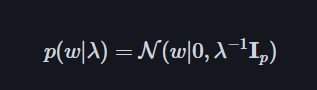

шо не ясно

In [350]:
bayes_model.get_params()

{'alpha_1': 1e-06,
 'alpha_2': 1e-06,
 'alpha_init': None,
 'compute_score': False,
 'copy_X': True,
 'fit_intercept': True,
 'lambda_1': 1e-06,
 'lambda_2': 1e-06,
 'lambda_init': None,
 'max_iter': 300,
 'tol': 0.001,
 'verbose': False}

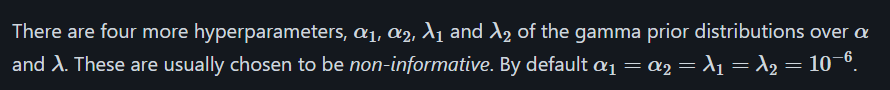

well, default it is then

# III. Дослідження ансамблевих методів

1. Використати ансамблеві моделі для покращення результатів:
• Bagging (Random Forest)
• Boosting (XGBoost, Gradient Boosting)
• Stacking (поєднання кількох моделей)
2. Додати ймовірнісні межі (min/max) для кожного прогнозу
3. Порівняти результати ансамблів із базовими моделями.

as both RF and CatBoost were used let's try stacking🐱‍👤

я зайшов на оф. доки і ооооо пайпи згодились

I'll use the same models as in the docs

In [352]:
lasso_pipe = Pipeline([
  ('preprocessor', preprocessor),
  ('model', Lasso()),
])
lasso_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['User_ID', 'Age', 'Height',
                                                   'Weight', 'Duration',
                                                   'Heart_Rate', 'Body_Temp']),
                                                 ('cat',
                                                  Pipeline(steps=[('one_hot_encoder',
                                                                   OneHotEncoder())]),
                                                  ['Gender'])])),
                ('model', Lasso())])

In [353]:
rf_pipe = Pipeline([
  ('preprocessor', preprocessor),
  ('model', RandomForestRegressor(n_estimators=10))
])
rf_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['User_ID', 'Age', 'Height',
                                                   'Weight', 'Duration',
                                                   'Heart_Rate', 'Body_Temp']),
                                                 ('cat',
                                                  Pipeline(steps=[('one_hot_encoder',
                                                                   OneHotEncoder())]),
                                                  ['Gender'])])),
                ('model', RandomForestRegressor(n_estimators=10))])

oi, they use some gradient boosting regressor

In [354]:
from sklearn.ensemble import HistGradientBoostingRegressor

In [355]:
boosting_pipe = Pipeline([
  ('preprocessor', preprocessor),
  ('model', HistGradientBoostingRegressor(random_state=0))
])
boosting_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['User_ID', 'Age', 'Height',
                                                   'Weight', 'Duration',
                                                   'Heart_Rate', 'Body_Temp']),
                                                 ('cat',
                                                  Pipeline(steps=[('one_hot_encoder',
                                                                   OneHotEncoder())]),
                                                  ['Gender'])])),
                ('model', HistGradientBoostingRegressor(random_state=0))])

but I also wanna ad my Elastic model🐱‍👤

In [356]:
elastic_pipe = Pipeline([
  ('preprocessor', preprocessor),
  ('model', ElasticNet(
    l1_ratio=0.75, 
    max_iter=1000,
    selection='random',
  ))
])
elastic_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['User_ID', 'Age', 'Height',
                                                   'Weight', 'Duration',
                                                   'Heart_Rate', 'Body_Temp']),
                                                 ('cat',
                                                  Pipeline(steps=[('one_hot_encoder',
                                                                   OneHotEncoder())]),
                                                  ['Gender'])])),
                ('model', ElasticNet(l1_ratio=0.75, selection='random'))])

stacking time🎂

In [360]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV

In [358]:
estimators = [
  ('Lasso', lasso_pipe),
  ('Random Forest', rf_pipe),
  ('ElasticNet', elastic_pipe),
  ('Gradient Boosting', boosting_pipe),
]

In [361]:
stacking_regressor = StackingRegressor(estimators=estimators, final_estimator=RidgeCV())
stacking_regressor

StackingRegressor(estimators=[('Lasso',
                               Pipeline(steps=[('preprocessor',
                                                ColumnTransformer(transformers=[('num',
                                                                                 Pipeline(steps=[('scaler',
                                                                                                  StandardScaler())]),
                                                                                 ['User_ID',
                                                                                  'Age',
                                                                                  'Height',
                                                                                  'Weight',
                                                                                  'Duration',
                                                                                  'Heart_Rate',
                                                                                  'Body_Temp']),
                                                                                ('cat',
                                                                                 Pipeline(steps=[('one_hot_encoder',
                                                                                                  OneHotEncoder())]),
                                                                                 ['Gender'])])),
                                               ('model', Lasso())])),
                              ('Random Forest',
                               Pipeline...
                               Pipeline(steps=[('preprocessor',
                                                ColumnTransformer(transformers=[('num',
                                                                                 Pipeline(steps=[('scaler',
                                                                                                  StandardScaler())]),
                                                                                 ['User_ID',
                                                                                  'Age',
                                                                                  'Height',
                                                                                  'Weight',
                                                                                  'Duration',
                                                                                  'Heart_Rate',
                                                                                  'Body_Temp']),
                                                                                ('cat',
                                                                                 Pipeline(steps=[('one_hot_encoder',
                                                                                                  OneHotEncoder())]),
                                                                                 ['Gender'])])),
                                               ('model',
                                                HistGradientBoostingRegressor(random_state=0))]))],
                  final_estimator=RidgeCV())

nooooowww let's copy and paste entire script from these fancy docs of theirs

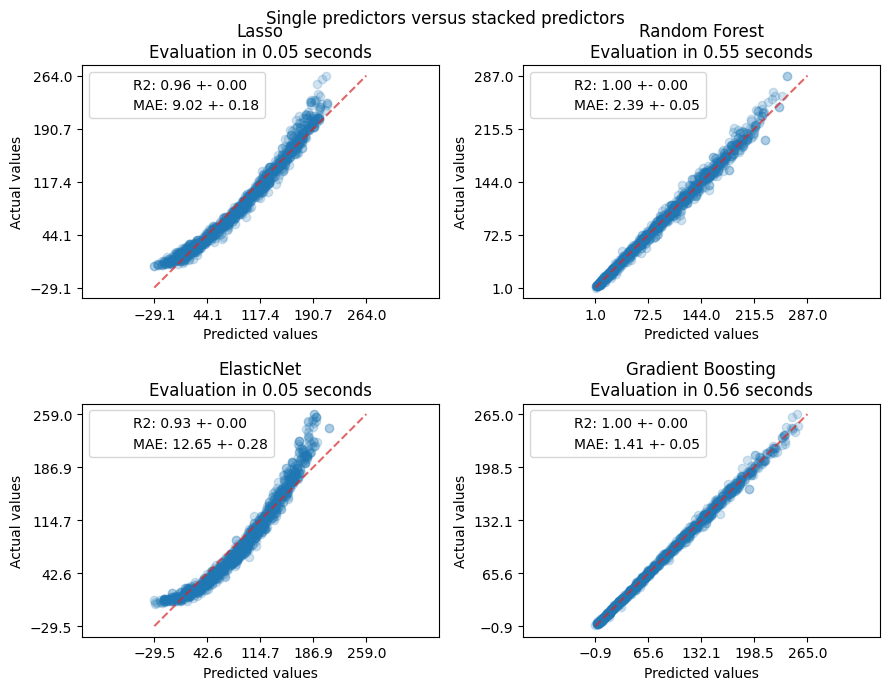

In [375]:
import time

import matplotlib.pyplot as plt

from sklearn.metrics import PredictionErrorDisplay
from sklearn.model_selection import cross_val_predict, cross_validate

fig, axs = plt.subplots(2, 2, figsize=(9, 7))
axs = np.ravel(axs)

for ax, (name, est) in zip(
    axs, estimators + [("Stacking Regressor", stacking_regressor)]
):
    scorers = {"R2": "r2", "MAE": "neg_mean_absolute_error"}

    start_time = time.time()
    scores = cross_validate(
        est, X_train_scaled, y_train, scoring=list(scorers.values()), n_jobs=-1, verbose=0
    )
    elapsed_time = time.time() - start_time

    # i'm using test data for prediction
    y_pred = cross_val_predict(est, X_test_scaled, y_test, n_jobs=-1, verbose=0)
    scores = {
        key: (
            f"{np.abs(np.mean(scores[f'test_{value}'])):.2f} +- "
            f"{np.std(scores[f'test_{value}']):.2f}"
        )
        for key, value in scorers.items()
    }
    # MetricsManager.confidence_intervals(X_train_scaled, y_train, X_test_scaled)

    display = PredictionErrorDisplay.from_predictions(
        y_true=y_test,
        y_pred=y_pred,
        kind="actual_vs_predicted",
        ax=ax,
        scatter_kwargs={"alpha": 0.2, "color": "tab:blue"},
        line_kwargs={"color": "tab:red"},
    )
    ax.set_title(f"{name}\nEvaluation in {elapsed_time:.2f} seconds")

    for name, score in scores.items():
        ax.plot([], [], " ", label=f"{name}: {score}")
    ax.legend(loc="upper left")

plt.suptitle("Single predictors versus stacked predictors")
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

what if we use my func?

In [372]:
stacking_regressor.predict(X_test_scaled)

ValueError: Found unknown categories [-0.9933554081432371, 1.0066890377827438] in column 0 during transform

I'm too tired to deal with this, let's move on for now and I'll come back to it later

confidence intervals? ☕☕☕

# IV. Перехід від регресії до класифікації

1. Перетворити регресію на класифікацію, розбивши цільову змінну на 
класи з використанням рівномірного поділу (дискретизації)(Equal-width 
binning)
2. Навчити класифікатори (наприклад, логістичну регресію, дерево рішень, 
XGBoost).
3. Оцінити якість класифікації за метриками:
• Accuracy (точність класифікації)
• Precision, Recall, F1-score
• Confusion Matrix
4. Повторити кроки 1-3 використовуючи інший крок дискретизації та 
порівняти результати


In [527]:
from sklearn.preprocessing import KBinsDiscretizer

n_bins = 2
kbd = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')

In [528]:
y_train_class = kbd.fit_transform(y_train.values.reshape(-1, 1)).astype(int).ravel()
y_test_class = kbd.transform(y_test.values.reshape(-1, 1)).astype(int).ravel()

In [529]:
pd.Series(y_train_class).value_counts()

0    9939
1    2061
Name: count, dtype: int64

In [530]:
lr_model.fit(X_train_scaled, y_train_class)
y_pred_class = lr_model.predict(X_test_scaled)
MetricsManager.print_metrics(y_test_class, y_pred_class)

 - MAE: 0.071, RMSE: 0.266, R^2: 0.532


[0.07101935046573668, 0.26649455991771515, 0.5315754825021635]

let's take some random models and check

In [531]:
rand_models = random.choices(models, k=3)
print(rand_models)

[<catboost.core.CatBoostRegressor object at 0x000001F10B6449D0>, BayesianRidge(), LinearRegression()]


In [486]:
test_map = {}
for model in rand_models:
  model.fit(X_train_scaled, y_train_class)
  y_pred_class = model.predict(X_test_scaled)
  
  model_name = type(model).__name__
  metrics = MetricsManager.print_metrics(y_test_class, y_pred_class, model_name)
  test_map[model] = metrics
  
  # MetricsManager.print_classification_metrics(y_test_class, y_pred_class, model_name)
  
test_df = pd.DataFrame(test_map).T
test_df = test_df.rename({
  0: "mae",
  1: "rmse",
  2: "r2",
}, axis=1)
test_df

ElasticNet - MAE: 0.389, RMSE: 0.624, R^2: -0.017
LinearRegression - MAE: 0.099, RMSE: 0.315, R^2: 0.741
BayesianRidge - MAE: 0.099, RMSE: 0.315, R^2: 0.741


,mae,rmse,r2
ElasticNet(),0.389037,0.623729,-0.016832
LinearRegression(),0.099267,0.315066,0.740545
BayesianRidge(),0.099275,0.315079,0.740524


In [532]:
pd.Series(y_pred_class - y_pred_class.min()).describe()

count    3000.000000
mean        0.562507
std         0.270994
min         0.000000
25%         0.341280
50%         0.521171
75%         0.779646
max         1.266446
dtype: float64

In [533]:
pd.Series(y_test_class).describe()

count    3000.000000
mean        0.186333
std         0.389440
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
dtype: float64

In [534]:
accuracy_score(y_test_class, (y_pred_class - y_pred_class.min()).astype(int))

0.8883333333333333

# question ❗

I have an error when using y_pred_class as it is but when converted to int it is alright 

In [535]:
MetricsManager.print_classification_metrics(y_test_class, (y_pred_class - y_pred_class.min()).astype(int), "LR")

LR - Accuracy: 0.888, Precision: 0.901, Recall: 0.888, F1-score: 0.868
Confusion Matrix
[[2439    2]
 [ 333  226]]
]nClassification Report:
               precision    recall  f1-score   support

           0       0.88      1.00      0.94      2441
           1       0.99      0.40      0.57       559

    accuracy                           0.89      3000
   macro avg       0.94      0.70      0.76      3000
weighted avg       0.90      0.89      0.87      3000



In [547]:
def discretize_by(n_bins, model) -> tuple[list, list]:
  kbd = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')
  y_train_class = kbd.fit_transform(y_train.values.reshape(-1, 1)).astype(int).ravel()
  y_test_class = kbd.fit_transform(y_test.values.reshape(-1, 1)).astype(int).ravel()
  pd.Series(y_train_class).value_counts()
  
  model.fit(X_train_scaled, y_train_class)
  y_pred_class = model.predict(X_test_scaled)
  mae, rmse, r2 = MetricsManager.print_metrics(y_test_class, y_pred_class)
  
  acc, prec, rec, f1 = MetricsManager.print_classification_metrics(y_test_class, (y_pred_class - y_pred_class.min()).astype(int), type(model).__name__)
  return [mae, rmse, r2], [acc, prec, rec, f1]

In [563]:
basic_models = [
  LinearRegression(),
  Lasso(random_state=42),
  Ridge(),
  ElasticNet(),
  BayesianRidge(),
  RandomForestRegressor(),
  KNeighborsRegressor(),
]

In [564]:
res_full = {} 
for i in [2, 3, 4, 5]:
  res_map = {}
  for model in basic_models:
    reg_metrics, class_metrics = discretize_by(i, model)
    model_name = type(model).__name__
    res_map[model_name] = reg_metrics + class_metrics
  res_full[i] = res_map

 - MAE: 0.076, RMSE: 0.275, R^2: 0.566
LinearRegression - Accuracy: 0.851, Precision: 0.875, Recall: 0.851, F1-score: 0.820
Confusion Matrix
[[2324    0]
 [ 448  228]]

Classification Report:
               precision    recall  f1-score   support

           0       0.84      1.00      0.91      2324
           1       1.00      0.34      0.50       676

    accuracy                           0.85      3000
   macro avg       0.92      0.67      0.71      3000
weighted avg       0.87      0.85      0.82      3000

 - MAE: 0.177, RMSE: 0.421, R^2: -0.016
Lasso - Accuracy: 0.775, Precision: 0.600, Recall: 0.775, F1-score: 0.676
Confusion Matrix
[[2324    0]
 [ 676    0]]

Classification Report:
               precision    recall  f1-score   support

           0       0.77      1.00      0.87      2324
           1       0.00      0.00      0.00       676

    accuracy                           0.77      3000
   macro avg       0.39      0.50      0.44      3000
weighted avg       0.60  

c:\Users\Omen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Omen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Omen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

 - MAE: 0.031, RMSE: 0.177, R^2: 0.822
RandomForestRegressor - Accuracy: 0.881, Precision: 0.897, Recall: 0.881, F1-score: 0.863
Confusion Matrix
[[2324    0]
 [ 358  318]]

Classification Report:
               precision    recall  f1-score   support

           0       0.87      1.00      0.93      2324
           1       1.00      0.47      0.64       676

    accuracy                           0.88      3000
   macro avg       0.93      0.74      0.78      3000
weighted avg       0.90      0.88      0.86      3000

 - MAE: 0.041, RMSE: 0.202, R^2: 0.765
KNeighborsRegressor - Accuracy: 0.880, Precision: 0.896, Recall: 0.880, F1-score: 0.863
Confusion Matrix
[[2324    0]
 [ 360  316]]

Classification Report:
               precision    recall  f1-score   support

           0       0.87      1.00      0.93      2324
           1       1.00      0.47      0.64       676

    accuracy                           0.88      3000
   macro avg       0.93      0.73      0.78      3000
weighte

c:\Users\Omen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Omen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Omen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

 - MAE: 0.099, RMSE: 0.315, R^2: 0.741
BayesianRidge - Accuracy: 0.890, Precision: 0.901, Recall: 0.890, F1-score: 0.863
Confusion Matrix
[[1677   47    0]
 [  86  991    0]
 [   0  196    3]]

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96      1724
           1       0.80      0.92      0.86      1077
           2       1.00      0.02      0.03       199

    accuracy                           0.89      3000
   macro avg       0.92      0.64      0.62      3000
weighted avg       0.90      0.89      0.86      3000

 - MAE: 0.053, RMSE: 0.231, R^2: 0.860
RandomForestRegressor - Accuracy: 0.820, Precision: 0.828, Recall: 0.820, F1-score: 0.792
Confusion Matrix
[[1724    0    0]
 [ 361  716    0]
 [   0  180   19]]

Classification Report:
               precision    recall  f1-score   support

           0       0.83      1.00      0.91      1724
           1       0.80      0.66      0.73      1077
           2

c:\Users\Omen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Omen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Omen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

[[1392    0    0    0]
 [ 932    0    0    0]
 [ 609    0    0    0]
 [  67    0    0    0]]

Classification Report:
               precision    recall  f1-score   support

           0       0.46      1.00      0.63      1392
           1       0.00      0.00      0.00       932
           2       0.00      0.00      0.00       609
           3       0.00      0.00      0.00        67

    accuracy                           0.46      3000
   macro avg       0.12      0.25      0.16      3000
weighted avg       0.22      0.46      0.29      3000

 - MAE: 0.114, RMSE: 0.338, R^2: 0.839
BayesianRidge - Accuracy: 0.877, Precision: 0.872, Recall: 0.877, F1-score: 0.870
Confusion Matrix
[[1210  182    0    0]
 [   2  871   59    0]
 [   0   58  551    0]
 [   0    0   67    0]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.87      0.93      1392
           1       0.78      0.93      0.85       932
           2       0.81     

c:\Users\Omen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Omen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Omen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

ElasticNet - Accuracy: 0.391, Precision: 0.170, Recall: 0.391, F1-score: 0.237
Confusion Matrix
[[1172    0    0    0    0]
 [ 828    0    0    0    0]
 [ 609   45    0    0    0]
 [  89  219    0    0    0]
 [   0   38    0    0    0]]

Classification Report:
               precision    recall  f1-score   support

           0       0.43      1.00      0.61      1172
           1       0.00      0.00      0.00       828
           2       0.00      0.00      0.00       654
           3       0.00      0.00      0.00       308
           4       0.00      0.00      0.00        38

    accuracy                           0.39      3000
   macro avg       0.09      0.20      0.12      3000
weighted avg       0.17      0.39      0.24      3000

 - MAE: 0.145, RMSE: 0.381, R^2: 0.872
BayesianRidge - Accuracy: 0.787, Precision: 0.808, Recall: 0.787, F1-score: 0.786
Confusion Matrix
[[863 309   0   0   0]
 [  3 661 164   0   0]
 [  0   6 593  55   0]
 [  0   0  63 245   0]
 [  0   0   0  38  

c:\Users\Omen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Omen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Omen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [575]:
def peek_when_nbins(nbins) -> None:
  res_when_nbins = pd.DataFrame(res_full[nbins]).T
  return res_when_nbins.rename({
    0: "mae",
    1: "rmse",
    2: "r2",
    3: "acc",
    4: "prec",
    5: "recall",
    6: "f1"
  }, axis = 1)

In [581]:
peek_when_nbins(5)

,mae,rmse,r2,acc,prec,recall,f1
LinearRegression,0.144944,0.380715,0.871542,0.787000,0.808012,0.787000,0.786099
Lasso,1.143612,1.069398,-0.013536,0.390667,0.152620,0.390667,0.219492
Ridge,0.144953,0.380726,0.871535,0.787333,0.808305,0.787333,0.786396
ElasticNet,0.659856,0.812315,0.415198,0.390667,0.169704,0.390667,0.236621
BayesianRidge,0.144950,0.380723,0.871537,0.787333,0.808305,0.787333,0.786396
RandomForestRegressor,0.075003,0.273867,0.933528,0.703667,0.672279,0.703667,0.672073
KNeighborsRegressor,0.097787,0.312709,0.913336,0.720000,0.694418,0.720000,0.691599


# V. Дослідження розподілу ймовірностей у класифікації

1. Вивести розподіл ймовірностей передбачень для кожного класу 
(наприклад, через softmax або предикти у Random Forest).
2. Побудувати гістограму ймовірностей, щоб побачити впевненість моделі.
3. Дослідити, як змінюється розподіл при overfitting та underfitting:
  1) Побудувати графіки розподілу ймовірностей для різних моделей
  2) Пояснити, як виглядає перенавчання і недонавчання через ймовірності 
передбачень

In [585]:
n_bins = 4
kbd = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')
y_train_class = kbd.fit_transform(y_train.values.reshape(-1, 1)).astype(int).ravel()
y_test_class = kbd.fit_transform(y_test.values.reshape(-1, 1)).astype(int).ravel()
  
from sklearn.ensemble import RandomForestClassifier
    
rf_model_class = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_class.fit(X_train_scaled, y_train_class)
y_proba_class = rf_model_class.predict_proba(X_test_scaled)

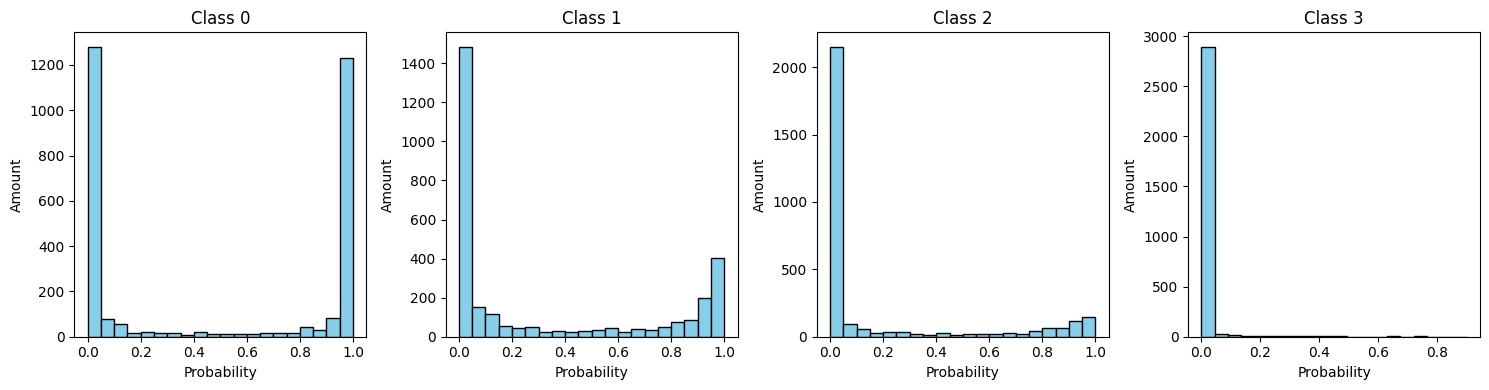

In [586]:
plt.figure(figsize=(15, 4))
for i in range(n_bins):
  plt.subplot(1, n_bins, i+1)
  plt.hist(y_proba_class[:, i], bins=20, color='skyblue', edgecolor='black')
  plt.title(f"Class {i}")
  plt.xlabel("Probability")
  plt.ylabel("Amount")
plt.tight_layout()
plt.show()

свіснув код з методички

In [ ]:
# Порівняння перспектив на класифікації

print("=== Порівняння ===")
print("Перспективна задача (Random Forest):")
print(" RMSE = {:.3f}".format(rmse_rf))
print(" MAE = {:.3f}".format(mae_rf))
print("")

print("Класифікаційна задача (Оптимізований Decision Tree):")
acc_clf = accuracy_score(y_test_class, y_pred_dtc_opt)
print(" Accuracy = {:.3f}".format(acc_clf))

# Обчислюємо ширину класу (w) по розмах цільової змінної (R)
# Для дискретизації використовувалось n_bins = 4
n_bins = 4
y_min, y_max = y_test.min(), y_test.max()
R = y_max - y_min  # розмах цільової змінної
w = R / n_bins  # ширина кожного класу

# 1. Перетворення MAE перспектив у точність класифікації:
# Формула: accuracy = 1 - (MAE / w)
acc_from_mae = 1 - (mae_rf / w)

# 2. Перетворення точності класифікації у MAE:
# Формула: MAE = (1 - accuracy) * R + (w / 2)
mae_from_acc = (1 - acc_clf) * R + (w / 2)

print("\n=== Перетворення за формулами ===")
print("MAE перспектив ({:.3f}) отримуємо приблизну точність: {:.3f}".format(mae_rf, acc_from_mae))
print("(Формула: accuracy = 1 - MAE / w, де w = {:.2f})".format(w))
print("")
print("Точності класифікації ({:.3f}) отримуємо приблизну MAE: {:.3f}".format(acc_clf, mae_from_acc))
print("(Формула: MAE = (1 - accuracy) * R + w/2, де R = {:.2f}, w = {:.2f})".format(R, w))


In [ ]:
----- Дискретизація прогнозів регресії для оцінки точності -----

# Використовуємо KBinsDiscretizer, який застосовувався для формування класів (наприклад, n_bins = 4)
# Дискретизуємо регресійні прогнозування з Random Forest
reg_pred_class = kbd.transform(y_pred_rf.reshape(-1, 1)).astype(int).ravel()

# Обчислюємо точність. Дискретизовані прогнози порівнюємо з фактичними класами
accuracy_reg_pred = accuracy_score(y_test_class, reg_pred_class)
print("Точність дискретизованих прогнозів регресії =", accuracy_reg_pred)

## Оцінка MAE через середні значення класів

# Обчислюємо середнє значення цільової змінної для кожного класу (на тренувальних даних)
# y_train_class вже отриманий раніше при дискретизації y_train
class_means = {}
for cls in range(n_bins):
    # Якщо у класі є спостереження, обчислюємо середнє; інакше використовуємо середину інтервалу
    cls_vals = y_train[y_train_class == cls]
    if len(cls_vals) > 0:
        class_means[cls] = cls_vals.mean()
    else:
        # Використовуємо середину інтервалу для цього класу
        bin_edges = kbd.bin_edges_[0]
        class_means[cls] = (bin_edges[cls] + bin_edges[cls+1]) / 2

# Замінюємо дискретизовані прогнозування у середні відповідних класів
mapped_reg_pred = np.array([class_means[cls] for cls in reg_pred_class])

# Обчислюємо MAE між заміненими прогнозами та фактичними значеннями
mae_mapped = np.mean(np.abs(y_test.values - mapped_reg_pred))
print("MAE для регресії після заміни дискретизованих прогнозів середніми значеннями класів =", mae_mapped)

# Візуалізація: порівняння фактичних значень та "mapped" прогнозів для перших 50 зразків
plt.figure(figsize=(12,6))
indices = np.arange(50)
plt.plot(indices, y_test.values[:50], 'bo-', label='Фактичні значення')
plt.plot(indices, mapped_reg_pred[:50], 'ro-', label='Mapped прогноз')
plt.xlabel("Індекс зразка")
plt.ylabel("Цільова змінна")
plt.title("Дискретизація прогнозів регресії та оцінка MAE через середні значення класів")
plt.legend()
plt.show()